                                                  review sentiment
33553  I really liked this Summerslam due to the look...  positive
9427   Not many television shows appeal to quite as m...  positive
199    The film quickly gets to a major chase scene w...  negative
12447  Jane Austen would definitely approve of this o...  positive
39489  Expectations were somewhat high for me when I ...  negative
sentiment
positive    12517
negative    12483
Name: count, dtype: int64

=== Tópicos LDA ===
Tópico 0:  ['comedies', 'thinks', 'liners', 'quirky', 'resolution', 'satisfy', 'closed', 'jim', 'leland', 'carrey']
Tópico 1:  ['rats', 'hood', 'brooks', 'robin', 'ollie', 'muppet', 'hardy', 'garbo', 'stan', 'laurel']
Tópico 2:  ['life', 'just', 'time', 'good', 'great', 'like', 'story', 'movie', 'film', 'br']
Tópico 3:  ['net', 'players', 'stephen', 'filler', 'duke', 'enjoys', 'ease', 'cup', 'tremendous', 'soccer']
Tópico 4:  ['troma', 'lemmon', 'fay', 'matthau', 'argento', 'hartley', 'branagh', 'sha

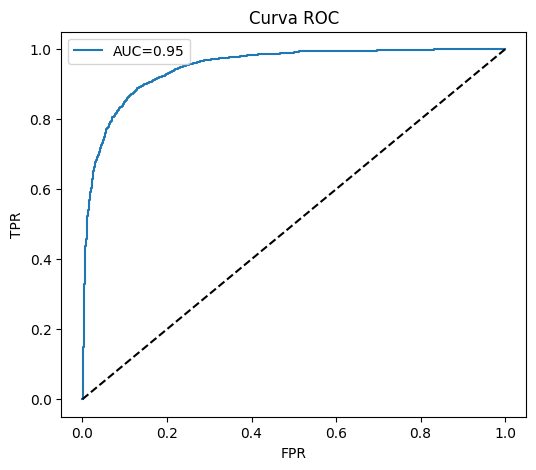

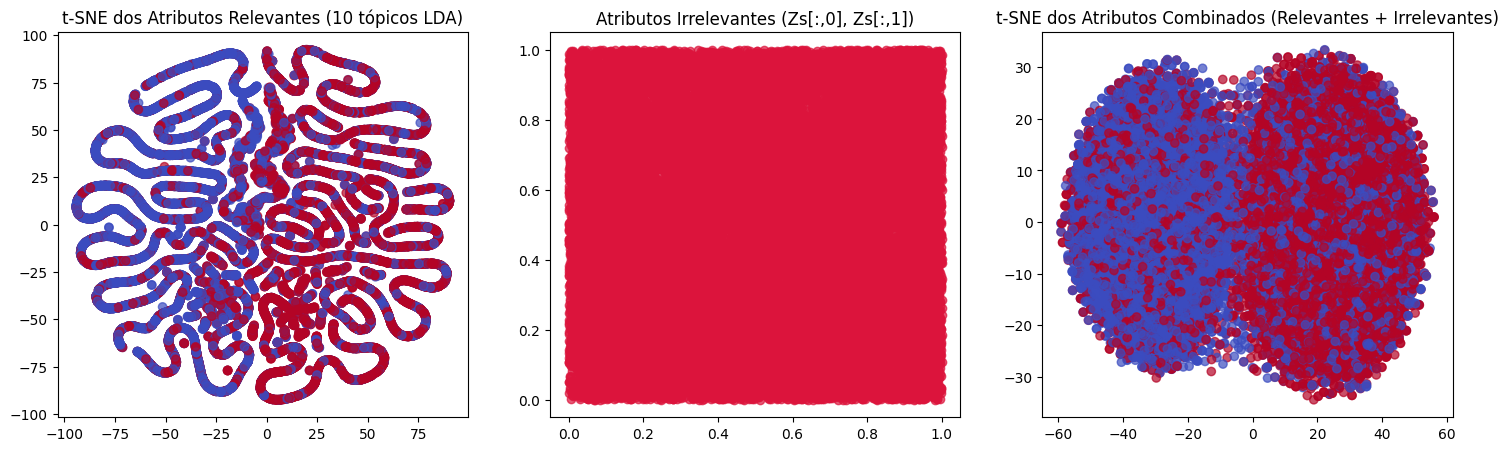


=== LIME - Explicação do Review ===
worst: -0.1689
boring: -0.1166
beautiful: 0.0647
mediocre: -0.0624
Christian: -0.0612
pulls: 0.0468
moved: 0.0449
just: -0.0370
thing: -0.0267
shame: -0.0265


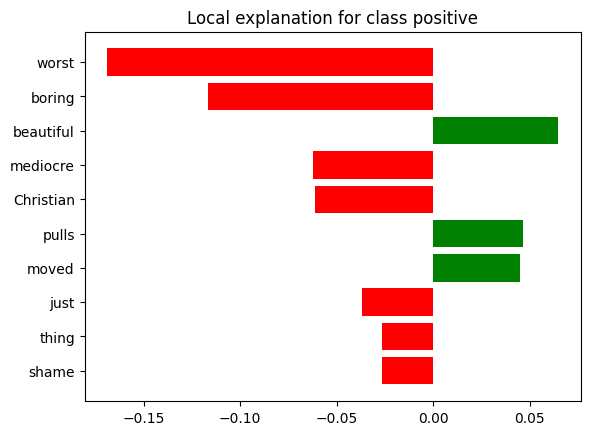


Probabilidade do modelo - Negative: 0.9225, Positive: 0.0775
Classe prevista pelo modelo: negative


In [96]:
# =========================
# 0. Setup e Carregamento
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import manifold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")

# Carregando dataset
df = pd.read_csv(
    "dataset.csv",
    engine="python",
    quoting=1,          # trata textos entre aspas duplas
    on_bad_lines="skip" # ignora linhas quebradas
)

# Seleciona numero de amostras aleatorias
df = df.sample(n=25000, random_state=42)

# Mostra primeiras linhas e distribuição de classes
print(df.head())
print(df["sentiment"].value_counts())

# Converte o target 'sentiment' em variável binária
df["label"] = df["sentiment"].map({"positive": 1, "negative": 0})

# =========================
# 1. Criação de Features - TF-IDF
# =========================

# Representa os textos como vetores numéricos (bag of words + ponderação TF-IDF)
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = tfidf.fit_transform(df["review"])
y = df["label"]

# =========================
# 2. Modelagem de Tópicos - LDA
# =========================

# Reduz a dimensionalidade textual extraindo topicos latentes
n_topics = 25
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X_tfidf)

# Mostra os 10 termos mais representativos de cada tópico
terms = tfidf.get_feature_names_out()
print("\n=== Tópicos LDA ===")
for idx, topic in enumerate(lda.components_):
    print(f"Tópico {idx}: ", [terms[i] for i in topic.argsort()[-10:]])

# Para cada documento, obtém distribuição de probabilidade nos tópicos
X_topics = lda.transform(X_tfidf)

# =========================
# 3. Classificação de Textos
# =========================

# Divide dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

# Ajusta modelo de Regressão Logística com busca de hiperparâmetros
clf = GridSearchCV(
    LogisticRegression(max_iter=1000), 
    param_grid={"C":[0.01,0.1,1,10]},   # diferentes valores de regularizaçao
    cv=5, scoring="f1"                  # métrica escolhida: F1-score
)
clf.fit(X_train, y_train)
print("\nMelhor modelo:", clf.best_params_)

# =========================
# 4. Avaliação
# =========================

# Predição no conjunto de teste
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("\n=== Relatório de Classificação ===")
print(classification_report(y_test, y_pred))

# AUC (área sob a curva ROC)
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Plot da curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1],[0,1],"k--") # linha aleatoria
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.legend()
plt.show()

# =========================
# 5. Visualização com t-SNE
# =========================

# visualizar os dados em 2D usando redução de dimensionalidade

# Número de amostras
n_samples = X_topics.shape[0]

# Usa os tópicos como atributos relevantes
X_relevantes = X_topics  # shape (n_samples, n_topics)

# Cria atributos irrelevantes artificiais
Zs = np.random.uniform(0, 1, size=(n_samples, 25))

# Concatena relevantes + irrelevantes
atributos = np.concatenate((X_relevantes, Zs), axis=1)

# Aplica t-SNE nos atributos combinados
tsne = manifold.TSNE(
    n_components=2,
    perplexity=40,
    learning_rate=300,
    random_state=42,
    max_iter=1000
)
atributos_tsne = tsne.fit_transform(atributos)

# Plotagem comparativa
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# 1. t-SNE apenas com atributos relevantes
tsne_relevantes = manifold.TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    max_iter=1000
).fit_transform(X_relevantes)
axes[0].scatter(tsne_relevantes[:,0], tsne_relevantes[:,1], alpha=0.7, c=df['label'].values, cmap='coolwarm')
axes[0].set_title("t-SNE dos Atributos Relevantes (10 tópicos LDA)")

# 2. Apenas duas features irrelevantes
axes[1].scatter(Zs[:,0], Zs[:,1], color='Crimson', alpha=0.7)
axes[1].set_title("Atributos Irrelevantes (Zs[:,0], Zs[:,1])")

# 3. t-SNE dos atributos combinados
axes[2].scatter(atributos_tsne[:,0], atributos_tsne[:,1], alpha=0.7, c=df['label'].values, cmap='coolwarm')
axes[2].set_title("t-SNE dos Atributos Combinados (Relevantes + Irrelevantes)")

plt.show()

# =========================
# 6. Interpretação de Modelos com LIME, SHAP e Force-Plot
# =========================

# 6.1 LIME
# =========================

# Cria pipeline TF-IDF + melhor modelo encontrado
c = make_pipeline(tfidf, clf.best_estimator_)

# Inicializa o LIME para dados textuais
explainer_lime = LimeTextExplainer(class_names=["negative", "positive"])

# Escolhe um review de teste para explicar
idx = 10
texto_exemplo = df["review"].iloc[idx]

# Gera explicação do modelo para esse texto
exp = explainer_lime.explain_instance(
    text_instance=texto_exemplo,
    classifier_fn=c.predict_proba,
    num_features=10
)

# Mostra palavras e pesos (influência positiva/negativa)
print("\n=== LIME - Explicação do Review ===")
for word, weight in exp.as_list():
    print(f"{word}: {weight:.4f}")

# Gera gráfico estático com a explicação
fig = exp.as_pyplot_figure()
plt.show()

# Mostra a previsão original do modelo
pred_prob = c.predict_proba([texto_exemplo])[0]
print(f"\nProbabilidade do modelo - Negative: {pred_prob[0]:.4f}, Positive: {pred_prob[1]:.4f}")
print(f"Classe prevista pelo modelo: {'positive' if pred_prob[1] > 0.5 else 'negative'}")

#TODO 6.2 SHAP
# =========================

